In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x, y):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x):
        if x.dim() != 2 or x.size(1) != self.in_features:
            x = x.view(x.size(0), -1)  # Flatten the tensor

        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from kan import KANLinear

class ConvNeXt_KAN(nn.Module):
    def __init__(self, num_classes=5):
        super(ConvNeXt_KAN, self).__init__()
        
        # Load ConvNeXt Base model (pretrained on ImageNet)
        self.convnext = models.convnext_base(pretrained=True)
        
        # Remove the final classification head
        self.convnext.classifier[2] = nn.Identity()
        
        # Define Kolmogorov-Arnold Network (KAN) layers
        self.kan_layers = nn.Sequential(
            KANLinear(1024, 512),
            nn.ReLU(),
            KANLinear(512, 256),
            nn.ReLU(),
            KANLinear(256, 128),
            nn.ReLU(),
            KANLinear(128, num_classes)  # Output layer
        )
        
    def forward(self, x):
        features = self.convnext(x)  # Extract features using ConvNeXt
        out = self.kan_layers(features)  # Classify using KAN
        return out

# Check model structure
if __name__ == "__main__":
    model = ConvNeXt_KAN(num_classes=5)
    sample_input = torch.randn(1, 3, 224, 224)  # Sample batch with batch size = 1
    output = model(sample_input)
    print("Model Output Shape:", output.shape)

c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to C:\Users\User/.cache\torch\hub\checkpoints\convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:55<00:00, 6.41MB/s] 


Model Output Shape: torch.Size([1, 5])


In [3]:
pip install timm


Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import timm  # For ConvNeXt
from kan import KANLinear  # Assuming KANLinear is implemented in kan.py

class ConvNeXt_KAN(nn.Module):
    def __init__(self, num_classes=5):
        super(ConvNeXt_KAN, self).__init__()
        
        # Load ConvNeXt-Tiny Model (Pretrained)
        self.backbone = timm.create_model('convnext_tiny', pretrained=True)
        
        # Remove the fully connected (FC) layer
        self.backbone.head.fc = nn.Identity()

        # Define KAN-based classifier
        self.kan_classifier = nn.Sequential(
            KANLinear(768, 256),  # Feature dim of ConvNeXt-Tiny is 768
            nn.ReLU(),
            KANLinear(256, 128),
            nn.ReLU(),
            KANLinear(128, 64),
            nn.ReLU(),
            KANLinear(64, num_classes)  # Output 5 classes
        )

    def forward(self, x):
        features = self.backbone(x)  # Extract features using ConvNeXt
        output = self.kan_classifier(features)  # Classify with KAN
        return output

# Model Initialization
model = ConvNeXt_KAN(num_classes=5)
print(model)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt_KAN(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): C

c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--timm--convnext_tiny.in12k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
from torchinfo import summary

model = ConvNeXtKAN()
summary(model, input_size=(1, 3, 224, 224))  # Batch size of 1


NameError: name 'ConvNeXtKAN' is not defined

In [6]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install torchsummary torchinfo


Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
from torchinfo import summary
from model import ConvNeXtKAN  # Import your model

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtKAN(num_classes=5).to(device)

# Print the model architecture with input size (batch_size, channels, height, width)
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])


c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ConvNeXtKAN                                        [1, 3, 224, 224]          [1, 5]                    --                        True
├─ConvNeXt: 1-1                                    [1, 3, 224, 224]          [1, 768, 1, 1]            --                        True
│    └─Sequential: 2-1                             [1, 3, 224, 224]          [1, 768, 7, 7]            --                        True
│    │    └─Conv2dNormActivation: 3-1              [1, 3, 224, 224]          [1, 96, 56, 56]           4,896                     True
│    │    └─Sequential: 3-2                        [1, 96, 56, 56]           [1, 96, 56, 56]           237,888                   True
│    │    └─Sequential: 3-3                        [1, 96, 56, 56]           [1, 192, 28, 28]          74,112                    True
│    │    └─Sequential: 3-4                        [1, 19

c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 100/100 [07:02<00:00,  4.23s/it]


Epoch 1: Loss = 1.1527, Accuracy = 48.44%


Epoch 2/10: 100%|██████████| 100/100 [06:49<00:00,  4.09s/it]


Epoch 2: Loss = 0.9371, Accuracy = 59.69%


Epoch 3/10: 100%|██████████| 100/100 [06:41<00:00,  4.01s/it]


Epoch 3: Loss = 0.7775, Accuracy = 67.75%


Epoch 4/10: 100%|██████████| 100/100 [06:21<00:00,  3.82s/it]


Epoch 4: Loss = 0.6470, Accuracy = 74.94%


Epoch 5/10: 100%|██████████| 100/100 [07:33<00:00,  4.54s/it]


Epoch 5: Loss = 0.5323, Accuracy = 79.06%


Epoch 6/10: 100%|██████████| 100/100 [07:16<00:00,  4.36s/it]


Epoch 6: Loss = 0.5050, Accuracy = 81.69%


Epoch 7/10: 100%|██████████| 100/100 [08:04<00:00,  4.85s/it]


Epoch 7: Loss = 0.3532, Accuracy = 87.44%


Epoch 8/10: 100%|██████████| 100/100 [07:00<00:00,  4.20s/it]


Epoch 8: Loss = 0.3053, Accuracy = 89.44%


Epoch 9/10: 100%|██████████| 100/100 [07:23<00:00,  4.44s/it]


Epoch 9: Loss = 0.2394, Accuracy = 92.44%


Epoch 10/10: 100%|██████████| 100/100 [07:27<00:00,  4.48s/it]


Epoch 10: Loss = 0.2068, Accuracy = 92.81%
Model saved as 'convnext_kan.pth'


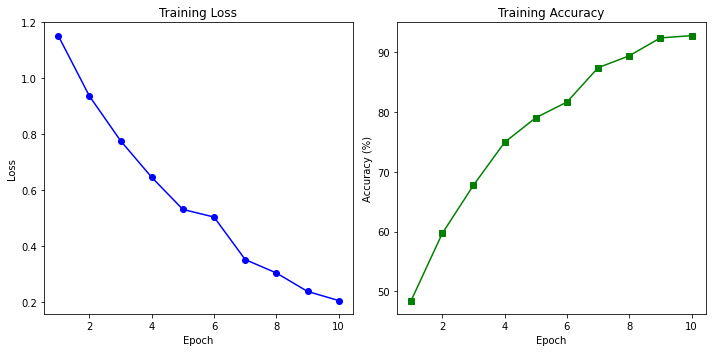

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import ConvNeXtKAN
from dataset import train_loader, class_names

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, and Optimizer
model = ConvNeXtKAN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

# Training function
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%')

    torch.save(model.state_dict(), "convnext_kan.pth")
    print("Model saved as 'convnext_kan.pth'")

# Run training
train(model, train_loader, criterion, optimizer, device)

# Plot Loss vs Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='s', linestyle='-', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()


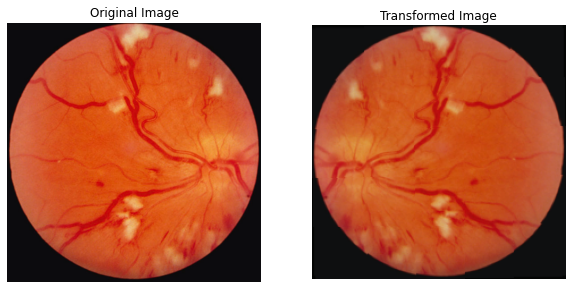

In [2]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the transformations as per your preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=20),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness & contrast adjustment
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Normalization
])

# Load an example image from your dataset
image_path = r"D:\final_KAN\DR_images.png"  # Change to an actual image path
original_image = Image.open(image_path).convert("RGB")  # Open and convert to RGB

# Apply transformation
transformed_image = transform(original_image)

# Convert tensor back to PIL image for visualization (unnormalizing for proper display)
unnormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                   std=[1/0.229, 1/0.224, 1/0.225])
transformed_image = unnormalize(transformed_image)
transformed_image = transforms.ToPILImage()(transformed_image)

# Plot original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(transformed_image)
ax[1].set_title("Transformed Image")
ax[1].axis("off")

plt.show()
